# Desafio semana 8 - Aceleradev em Data Science (codenation)


## Previsão da nota de matemática do ENEM 2016

No desafio desta semana voltamos aos mesmos dados que usamos naquele que foi o teste de entrada para o Aceleradev em *Data Science*. Mas, dessa vez estamos um pouco mais preparados para enfrentar o desafio.

O problema nada mais é que a previsão da nota de matématica da prova do enem de 2016.

Para isso temos os dois *Datasets* que serão usados e algumas ideias. 

Vamos lá.

In [33]:
# Importando as bibliotecas que usamemos por enquanto

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

plt.style.use('ggplot')
%matplotlib inline

Vamos carregar nossos conjuntos de dados.

In [4]:
# Criando os DataSets

df_train = pd.read_csv('train.csv', sep="," , encoding="UTF8" )
df_test = pd.read_csv('test.csv', sep="," , encoding="UTF8" )

E assim podemos conhecê-los.

In [5]:
# Conhecendo os dados

df_train.head()

Unnamed: 0                              NU_INSCRICAO  NU_ANO  \
0           1  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad    2016   
1           2  2c3acac4b33ec2b195d77e7c04a2d75727fad723    2016   
2           3  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568    2016   
3           4  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe    2016   
4           5  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268    2016   

   CO_MUNICIPIO_RESIDENCIA NO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA  \
0                  4314902            Porto Alegre                43   
1                  2304707                  Granja                23   
2                  2304400               Fortaleza                23   
3                  3304557          Rio de Janeiro                33   
4                  1302603                  Manaus                13   

  SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_ESTADO_CIVIL  ...  Q041  Q042  Q043  \
0               RS        24       M              0.0  ...   5.0     A     A   
1               CE        17       F              0.0  ...   NaN     A     A   
2               CE        21       F              0.0  ...   NaN     A     A   
3               RJ        25       F              0.0  ...   5.0     C     A   
4               AM        28       M              0.0  ...   NaN     A     A   

  Q044  Q045 Q046  Q047  Q048  Q049  Q050  
0    A     A    A     A     A     B     D  
1    C     A    B     A     A     C     A  
2    A     A    C     A     A     B     A  
3    A     A    A     D     A     A     A  
4    A     A    A     A     A     A     A  

[5 rows x 167 columns]

In [6]:
# conhecendo os dados

df_test.head()

NU_INSCRICAO  CO_UF_RESIDENCIA  \
0  73ff9fcc02f0a99919906c942c2e1a1042cdcf98                41   
1  71a95f9f1b91a82c65ad94abbdf9f54e6066f968                21   
2  b38a03232f43b11c9d0788abaf060f7366053b6d                23   
3  70b682d9a3636be23f6120fa9d6b164eb3c6002d                15   
4  715494628a50142ce8cb17191cfe6d0f3cae0934                41   

  SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  \
0               PR        22       F            3                 1   
1               MA        26       F            3                 1   
2               CE        21       M            1                 1   
3               PA        27       F            3                 1   
4               PR        18       M            1                 1   

   TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  ...  NU_NOTA_COMP5  \
0                1                5          1  ...           40.0   
1                1                8          1  ...          100.0   
2                2                0          2  ...           80.0   
3                1                8          1  ...            NaN   
4                2                0          2  ...            0.0   

   NU_NOTA_REDACAO  Q001  Q002  Q006  Q024  Q025  Q026  Q027  Q047  
0            420.0     B     A     C     A     A     C     C     A  
1            580.0     E     B     C     B     B     B     F     A  
2            320.0     E     E     D     B     B     A   NaN     A  
3              NaN     H     E     G     B     B     A   NaN     A  
4            320.0     D     H     H     C     B     A   NaN     A  

[5 rows x 47 columns]

## Análise exploratória

Como podemos observar do *Dataset* de treinamento possui uma quantidade enorme de *features* o que nos dar um mar de opções para nossa análise. No entando, algumas dessas 167 variáveis são apenas informações de registros que certamante não possuem correlação com a nota desejada.

Já o *Dataset* de teste possue 47 variáveis, o que já nos dar uma base do que poderemos usar, já que teremos que usar *features* comuns em ambos.

Antes de seguimos com tudo, temos que ler todo o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Sendo assim, após uma longa análise e leitura escolhi umas variáveis que inicialmente julguei necessárias, poderiámos usar outra técnica de escolha de *features* mas para esse caso vamos nos ater as que escolhi. Algumas variáveis já eliminei por ter correlação 0, por exemplo: dados de cadastro.
disciplinas cobrados no exame.

Como podes observar abaixo, basicamente selecionei as *features* das notas de outras disciplina, confesso que anteriormente usei o Pandas Profiling para fazer uma exploração básica de correlação.

In [9]:
# Selecionando as features que vamos trabalhar nos dois datasets

features_train = ['NU_INSCRICAO', 'NU_NOTA_CH', 'NU_NOTA_CN',
                  'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                  'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_MT']

features_test = ['NU_INSCRICAO', 'NU_NOTA_CH', 'NU_NOTA_CN',
                  'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                  'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

Vamos conhecer também o tamanho dos conjuntos de dados.

In [10]:
# conhecendo o tamanho dos dados

df_train.shape, df_test.shape

((13730, 167), (4576, 47))

Agora podemo selecionar apenas as *features* que escolhemos anteriormente.

In [11]:
# Redimensionando os dadasets

df_train = df_train[features_train]
df_test = df_test[features_test]

E com isso podemos verificar a quantidade de colunas restantes aos nossos dados.

In [12]:
# verificando o shape após a exclusão

df_train.shape, df_test.shape

((13730, 11), (4576, 10))

In [13]:
df_train.head()

NU_INSCRICAO  NU_NOTA_CH  NU_NOTA_CN  \
0  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad       495.4       436.3   
1  2c3acac4b33ec2b195d77e7c04a2d75727fad723       544.1       474.5   
2  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568         NaN         NaN   
3  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe         NaN         NaN   
4  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268         NaN         NaN   

   NU_NOTA_LC  NU_NOTA_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  \
0       581.2            520.0          120.0          120.0          120.0   
1       599.0            580.0          140.0          120.0          120.0   
2         NaN              NaN            NaN            NaN            NaN   
3         NaN              NaN            NaN            NaN            NaN   
4         NaN              NaN            NaN            NaN            NaN   

   NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_MT  
0           80.0           80.0       399.4  
1          120.0           80.0       459.8  
2            NaN            NaN         NaN  
3            NaN            NaN         NaN  
4            NaN            NaN         NaN

Agora que já lemos o dicionário, entendemos e selecionamos as *features* que vamos trabalhar, podemos agora análisar e entender os *missing values*.

In [14]:
# Verificando so missing values

df_train[features_train].isna().sum()

NU_INSCRICAO          0
NU_NOTA_CH         3389
NU_NOTA_CN         3389
NU_NOTA_LC         3597
NU_NOTA_REDACAO    3597
NU_NOTA_COMP1      3597
NU_NOTA_COMP2      3597
NU_NOTA_COMP3      3597
NU_NOTA_COMP4      3597
NU_NOTA_COMP5      3597
NU_NOTA_MT         3597
dtype: int64

In [15]:
# Verificando os missing values

df_test[features_test].isna().sum()

NU_INSCRICAO          0
NU_NOTA_CH         1134
NU_NOTA_CN         1134
NU_NOTA_LC         1199
NU_NOTA_REDACAO    1199
NU_NOTA_COMP1      1199
NU_NOTA_COMP2      1199
NU_NOTA_COMP3      1199
NU_NOTA_COMP4      1199
NU_NOTA_COMP5      1199
dtype: int64

Como é fácil verificar acima, os exames são ministrados em dois dias o que explica os valores de *missing values* em dois grupos em cada conjunto.

Também vemos que o prova de matemática é realizada junto com a prova de redação.

Não podemos esquecer também de verificar as estatísticas básicas.

In [16]:
# Verificando as estatísticas básicas dos dados de treino

df_train.describe()

NU_NOTA_CH    NU_NOTA_CN    NU_NOTA_LC  NU_NOTA_REDACAO  \
count  10341.000000  10341.000000  10133.000000     10133.000000   
mean     529.661087    473.495155    516.472841       529.048258   
std       73.726344     71.093674     68.688190       154.294758   
min        0.000000      0.000000      0.000000         0.000000   
25%      480.400000    419.900000    468.100000       440.000000   
50%      532.000000    459.800000    520.900000       540.000000   
75%      581.200000    514.500000    564.900000       600.000000   
max      807.000000    806.400000    763.600000      1000.000000   

       NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  \
count   10133.000000   10133.000000   10133.000000   10133.000000   
mean      119.811704     111.915918     106.824238     113.123951   
std        29.846017      33.737588      34.341349      33.480033   
min         0.000000       0.000000       0.000000       0.000000   
25%       120.000000     100.000000      80.000000     100.000000   
50%       120.000000     120.000000     120.000000     120.000000   
75%       140.000000     120.000000     120.000000     120.000000   
max       200.000000     200.000000     200.000000     200.000000   

       NU_NOTA_COMP5    NU_NOTA_MT  
count   10133.000000  10133.000000  
mean       77.372446    482.497928  
std        43.067140     99.826323  
min         0.000000      0.000000  
25%        40.000000    408.900000  
50%        80.000000    461.200000  
75%       100.000000    537.600000  
max       200.000000    952.000000

Podemos verificar que a nota de matemática em média é de 482.

In [17]:
# Verificando as estatíscas básicas dos dados de testes

df_test.describe()

NU_NOTA_CH   NU_NOTA_CN   NU_NOTA_LC  NU_NOTA_REDACAO  NU_NOTA_COMP1  \
count  3442.000000  3442.000000  3377.000000      3377.000000    3377.000000   
mean    529.195264   473.136287   514.304205       527.491857     119.626888   
std      73.086665    70.995131    67.725564       151.979490      29.028146   
min       0.000000     0.000000     0.000000         0.000000       0.000000   
25%     479.725000   419.625000   468.400000       440.000000     120.000000   
50%     532.000000   458.250000   516.800000       540.000000     120.000000   
75%     579.550000   514.350000   562.400000       600.000000     140.000000   
max     773.600000   778.900000   708.900000       980.000000     200.000000   

       NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  
count    3377.000000    3377.000000    3377.000000    3377.000000  
mean      111.915902     106.384365     112.881256      76.683447  
std        33.296849      33.834492      33.202244      42.985637  
min         0.000000       0.000000       0.000000       0.000000  
25%       100.000000      80.000000     100.000000      40.000000  
50%       120.000000     100.000000     120.000000      80.000000  
75%       120.000000     120.000000     120.000000     100.000000  
max       200.000000     200.000000     200.000000     200.000000

Ao analisar as médias das *features* vemos que há uma equivalência entre os conjuntos, isso é uma informação interessante, pois significa menos ruidos.

Podemos também plotar o *heatmap* para verificarmos a correlação entre nossas *features*.

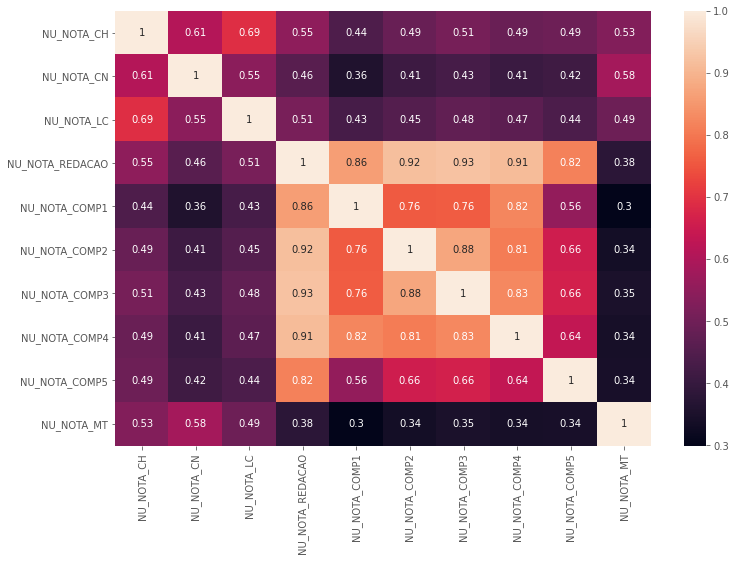

In [18]:
# Plotando o heatmap das features de treinamento

corr = df_train[features_train].corr()
ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10});

Podemos concluir nossa análise utilizando o pandas profiling, mas devo informar que sempre que possível começo por ele.

Iremos verifcar a distribuição dos dados em cada variável e as correlações em diferentes formas, além de podermos verificar o tipo e as quantidades de zeros por variável.

Em fim, eu sempre tiro muitos conclusões e construo outras com o relatório do pandas profiling.

In [19]:
from pandas_profiling import ProfileReport

In [21]:
profile = ProfileReport(df_train, title='Relatório - Pandas Profiling', html={'style':{'full_width':True}})
profile

Caso deseje salvar o relatório acima, você pode usar o seguinte código: profile.to_file(output_file="exemplo.html")

## Lidando com os Missing Values

Agora que conhecemos os dados, seus tipos, suas distribuições e correlações, podemos lidar os valores faltantes.

Existe inúmeras formas de se lidar com valores ausentes, no entanto, não acredito que substituir pela média ou mediana seria a forma correta, já que, esses valores ausentes são de pessoas que faltaram ou de alguma forma teve a mesma cancelada.


Com isso, preencheremos todos os dados faltantes com 0, afinal essa é a nota de quem não foi realizá-la.

In [22]:
# Preencher os dados faltantes com 0 para os dados de treino

df_train.fillna(0, inplace=True)

df_train.isna().sum()

NU_INSCRICAO       0
NU_NOTA_CH         0
NU_NOTA_CN         0
NU_NOTA_LC         0
NU_NOTA_REDACAO    0
NU_NOTA_COMP1      0
NU_NOTA_COMP2      0
NU_NOTA_COMP3      0
NU_NOTA_COMP4      0
NU_NOTA_COMP5      0
NU_NOTA_MT         0
dtype: int64

In [23]:
# Preencher os dados faltantes com 0 para os dados de treino

df_test.fillna(0, inplace=True)

df_test.isna().sum()

NU_INSCRICAO       0
NU_NOTA_CH         0
NU_NOTA_CN         0
NU_NOTA_LC         0
NU_NOTA_REDACAO    0
NU_NOTA_COMP1      0
NU_NOTA_COMP2      0
NU_NOTA_COMP3      0
NU_NOTA_COMP4      0
NU_NOTA_COMP5      0
dtype: int64

Como podes observar, nossas tratativas para os dados faltantes foram muito simples. Não espere isso de todas as situações, muitas vezes terá muito trabalho.

## Criando o Modelo de Machine Learning

Antes de partimos para criação dos nossos modelos, devo deixar claro que existe inúmeras maneiras de tratar e melhor a qualidade dos conjuntos antes de criação dos modelos, como: discretização, variáveis dummies, padronização e normalização.

Porém prentendo usar um modelo em *bagging* como conjuntos de árvores ou *random forest* e isso testarei com os dados assim, caso tenhamos uma *score* muito baixa (*score* mínima do desafio é 90%) trataremos novamente dos dados. 

Vamos seguir em frente.


In [24]:
# Salvando a variável de 'nu_inscricao'

nu_inscricao = df_test['NU_INSCRICAO']

In [25]:
# drop da variávl 'nu_inscricao' do conjunto de dados de teste

df_test.drop(['NU_INSCRICAO'], axis=1, inplace=True)

In [26]:
# drop da variávl 'nu_inscricao' do conjunto de dados de treino

df_train.drop(['NU_INSCRICAO'], axis=1, inplace=True)

In [27]:
# Vamos verificar os shape dos dados finais

df_test.shape, df_train.shape

((4576, 9), (13730, 10))

In [28]:
# Ainda temos a nossa variável 'target'

y = df_train['NU_NOTA_MT']

In [29]:
# Agora sim fazer o drop dos dados de treino

x = df_train.drop(['NU_NOTA_MT'], axis=1)
x

NU_NOTA_CH  NU_NOTA_CN  NU_NOTA_LC  NU_NOTA_REDACAO  NU_NOTA_COMP1  \
0           495.4       436.3       581.2            520.0          120.0   
1           544.1       474.5       599.0            580.0          140.0   
2             0.0         0.0         0.0              0.0            0.0   
3             0.0         0.0         0.0              0.0            0.0   
4             0.0         0.0         0.0              0.0            0.0   
...           ...         ...         ...              ...            ...   
13725       419.7       438.2       394.5            440.0          120.0   
13726       557.9       423.8       533.0            560.0          120.0   
13727       528.9       460.5       569.3            600.0          120.0   
13728       621.7       422.5       569.0            460.0          100.0   
13729       575.3       488.7       565.9            520.0          120.0   

       NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  
0              120.0          120.0           80.0           80.0  
1              120.0          120.0          120.0           80.0  
2                0.0            0.0            0.0            0.0  
3                0.0            0.0            0.0            0.0  
4                0.0            0.0            0.0            0.0  
...              ...            ...            ...            ...  
13725          120.0           80.0           80.0           40.0  
13726          120.0          120.0          120.0           80.0  
13727          120.0          120.0          120.0          120.0  
13728          100.0           80.0           80.0          100.0  
13729          120.0           80.0          120.0           80.0  

[13730 rows x 9 columns]

E agora vou submeter os dados em uma técnica de validação cruzada, vou usar o método *k-fold*.

Para verificar de forma mais confiável e segura, vou usar o *repeated* do *sklearn* na qual vamos fazer *splits* difrentes alterando as *seeds* do gerador de dados pseudo-aleatórios.

Neste caso, farei 10 repetições com 2 *splits* o que resultará em 20 amostras, assim, basta tirar a média e teremos uma acurária mais precisa já que verificamos a capacidade de generalização com dados que eles nunca viram.

In [30]:
from sklearn.model_selection import RepeatedKFold

In [36]:
resultados = []

kfold = RepeatedKFold(n_splits=2, n_repeats=10, random_state=1)
    
for linhas_train, linhas_valid in kfold.split(x):
    print('train:', linhas_train.shape[0])
    print('valid:', linhas_valid.shape[0])
    
    x_train, x_valid = x.iloc[linhas_train], x.iloc[linhas_valid]
    y_train, y_valid = y.iloc[linhas_train], y.iloc[linhas_valid]
    
    model = RandomForestRegressor( 
           criterion='mae', 
           max_depth=8,
           max_leaf_nodes=None,
           min_impurity_split=None,
           min_samples_leaf=1,
           min_samples_split=2,
           min_weight_fraction_leaf=0.0,
           n_estimators= 500,
           n_jobs=-1,
           random_state=0,
           verbose=0,
           warm_start=False
)
       
    model.fit(x_train, y_train)
    
    pred = model.predict(x_valid)
    
    acc = model.score(x_valid, y_valid)
    resultados.append(acc)
        
    print('Acc:', acc)
    print()

train: 6865
valid: 6865
Acc: 0.925679882859601

train: 6865
valid: 6865
Acc: 0.9151779474208731

train: 6865
valid: 6865
Acc: 0.9196459504145628

train: 6865
valid: 6865
Acc: 0.9215495397431214

train: 6865
valid: 6865
Acc: 0.9192192449041684

train: 6865
valid: 6865
Acc: 0.9224674312688749

train: 6865
valid: 6865
Acc: 0.9195306972147089

train: 6865
valid: 6865
Acc: 0.9223878185181126

train: 6865
valid: 6865
Acc: 0.9192334228396692

train: 6865
valid: 6865
Acc: 0.9217475363512135

train: 6865
valid: 6865
Acc: 0.9215589055199812

train: 6865
valid: 6865
Acc: 0.9203014573550112

train: 6865
valid: 6865
Acc: 0.9216901007221454

train: 6865
valid: 6865
Acc: 0.9203927935793955

train: 6865
valid: 6865
Acc: 0.9223028695435466

train: 6865
valid: 6865
Acc: 0.9199099560072677

train: 6865
valid: 6865
Acc: 0.9241155519128138

train: 6865
valid: 6865
Acc: 0.9180692330520163

train: 6865
valid: 6865
Acc: 0.9215364262660608

train: 6865
valid: 6865
Acc: 0.9197155943863053



In [37]:
acc_rf = resultados
np.mean(acc_rf)

0.9208116179939726

Como podemos verificar esse método de validação é importantíssimo para avaliarmos a capacidade de generalização do nosso modelo e facilmente conseguimos ver que não há tanta aleatoriedade apesar de estarmos mudando os dados de treino e validação.

Testei os modelos *Random Forest Regressor* e *LGBM Regressor* dos quais tivemos os seguintes *scores*:

1. Radom Forest regressor: 0.9208116179939726
2. LGBM Regressor: 0.9175458202794156

Poderíamos aplicar agora métodos para ajustar os hiperparâmetros como *Random Search* e Otimização Bayesiana, no entanto nosso *score* já é o suficiente para o nosso desafio não irei aplicar.

Agora podemos treinar novamente o nosso modelo com todo o conjunto de dados para gerar o arquivo de submissão ao desafio.

In [38]:
# Definindo nosso parâmetros

model_rf = RandomForestRegressor( 
           criterion='mae', 
           max_depth=8,
           max_leaf_nodes=None,
           min_impurity_split=None,
           min_samples_leaf=1,
           min_samples_split=2,
           min_weight_fraction_leaf=0.0,
           n_estimators= 500,
           n_jobs=-1,
           random_state=0,
           verbose=0,
           warm_start=False
)


Vamos treinar o nosso modelo.

In [39]:
#Treinando o modelo

model_rf.fit(x, y)

RandomForestRegressor(criterion='mae', max_depth=8, n_estimators=500, n_jobs=-1,
                      random_state=0)

E agora realizar a predição.

In [40]:
# Realizando a predição

y_pred_test = model_rf.predict(df_test)

Assim podemos salvar os valores preditos e submeter ao desafio.

In [41]:
# Criando o dataframe para submissão

answer = pd.DataFrame()

Vamos agora criar o arquivo de submissão.

In [42]:
# Salvando a variável 'nu_inscricao'

answer['NU_INSCRICAO'] = nu_inscricao

In [43]:
# Salvando a nota predita

answer['NU_NOTA_MT'] = np.around(y_pred_test)

In [44]:
# Criando o arquivo de submissão

answer.to_csv('answer.csv', index=False, header=True)

## Conclusões

De fato, esse foi um desafio muito agradável. No entanto, fiz alguns testes de variáveis antes de definir estas que usamos, fique a vontande para testar mais.

Também parei na tratativa pois o *score* já estava dentro do aceitável, neste caso não preciso desprender mais esforço.

O resultado final após a submissão foi de 93.65%, *score* um pouco acima dos nossos testes e um bom resultado.